## Disclaimer

**Environment:** This notebook has been developped for running with:

- Julia v1.11.x
- JuMP.jl v1.23.x
- GLPK.jl v1.2.1
- HiGHS v1.12.1

**Author:** Xavier Gandibleux, Nantes (France)


----

## Exercise 3

Given the bi-objective 01 Unidimensional Knapsack Problem (bi-01UKP) formulated by 
$$z=\max\big\{(p^1x,\ p^2x) \mid wx \le c, \ x\in\{0,1\}^n\big\}$$

and the numerical instance corresponding to 
$$n=5$$
$$p^1=(\ 6, \ 4, \ 4, \ 4, \ 3)$$
$$p^2=(12, 10, \ 5, \ 3, \ 1)$$
$$w=(\ 8, \ 6, \ 4, \ 3, \ 2)$$
$$c=15$$

answer to the following questions:

1. implement an implicit formulation of the bi-01UKP with JuMP and display the model.
2. using the package `MultiObjectiveAlgorithms`, compute and display $X_E$ and $Y_N$, the set of efficient solutions and the set of non-dominated points.
3. plot $Y_N$
4. using this learning, implement the required codes to solve instances of the bi-objective General Assignment Problem (biGAP).


## Answers:

----
### 1. implement an implicit formulation of the bi-01UKP with JuMP and display the model.

#### declare the packages to use:

In [17]:
using JuMP
using GLPK
import MultiObjectiveAlgorithms as MOA

#### setup the instance to solve

In [18]:
p1 = [ 13, 10, 3, 16, 12, 11,  1,  9, 19, 13 ] # profit 1
p2 = [  1, 10, 3, 13, 12, 19, 16, 13, 11,  9 ] # profit 2
w  = [  4,  4, 3,  5,  5,  3,  2,  3,  5,  4 ] # weight
c  = 19                                        # capacity
n  = length(p1)           # number of items

10

In [88]:
c/sum(w)

0.5

#### setup the formulation

In [19]:
bi01UKP = Model( )

@variable(bi01UKP, x[1:n], Bin)

@expression(bi01UKP, objective1, sum(p1[i] * x[i] for i in 1:n))
@expression(bi01UKP, objective2, sum(p2[i] * x[i] for i in 1:n))
@objective(bi01UKP, Max, [objective1, objective2])

@constraint(bi01UKP, sum(w[i] * x[i] for i in 1:n) ≤ c)

print(bi01UKP)

---- 
### 2. using the package `MultiObjectiveAlgorithms`, compute $Y_N$, the set of non-dominated points.

#### setup the MIP solver to use

In [20]:
set_optimizer(bi01UKP, () -> MOA.Optimizer(GLPK.Optimizer))

#### setup the algorithm to use

In [21]:
set_attribute(bi01UKP, MOA.Algorithm(), MOA.EpsilonConstraint())

#### solve the problem

In [22]:
optimize!(bi01UKP)
@assert termination_status(bi01UKP) == OPTIMAL
solution_summary(bi01UKP)

* Solver : MOA[algorithm=MultiObjectiveAlgorithms.EpsilonConstraint, optimizer=GLPK]

* Status
  Result count       : 6
  Termination status : OPTIMAL
  Message from the solver:
  "Solve complete. Found 6 solution(s)"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : [4.90000e+01,7.30000e+01]
  Objective bound    : [6.50000e+01,7.30000e+01]

* Work counters
  Solve time (sec)   : 1.34008e-01


#### query the cardinality of $Y_N$

In [23]:
result_count(bi01UKP)

6

In [24]:
items_selected = [i for i in 1:n if value(x[i]; result = 3) > 0.9]

5-element Vector{Int64}:
 2
 4
 6
 7
 9

#### query the summary of the 3rd point

In [25]:
solution_summary(bi01UKP; result = 3)

* Solver : MOA[algorithm=MultiObjectiveAlgorithms.EpsilonConstraint, optimizer=GLPK]

* Status
  Result count       : 6
  Termination status : OPTIMAL

* Candidate solution (result #3)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : [5.70000e+01,6.90000e+01]


#### query the vector values of the 3rd point

In [26]:
objective_value(bi01UKP; result = 3)

2-element Vector{Float64}:
 57.0
 69.0

#### query the value for the first objective of the 3rd point

In [27]:
value(objective1; result = 3)

57.0

#### display $X_E$ and $Y_N$

In [28]:
for i in 1:result_count(bi01UKP)
    @assert is_solved_and_feasible(bi01UKP; result = i)
    print(i, ": x = ", round.(Int, value.(x; result = i)), " | ")
    println("z = ", round.(Int, objective_value(bi01UKP; result = i)))
end

1: x = [0, 0, 0, 1, 1, 1, 1, 1, 0, 0] | z = [49, 73]
2: x = [0, 0, 0, 1, 0, 1, 1, 1, 1, 0] | z = [56, 72]
3: x = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0] | z = [57, 69]
4: x = [0, 0, 0, 1, 0, 1, 1, 0, 1, 1] | z = [60, 68]
5: x = [0, 1, 0, 0, 0, 1, 0, 1, 1, 1] | z = [62, 62]
6: x = [1, 0, 0, 0, 0, 1, 0, 1, 1, 1] | z = [65, 53]


----
### 3. plot $Y_N$ 

In [99]:
import Plots

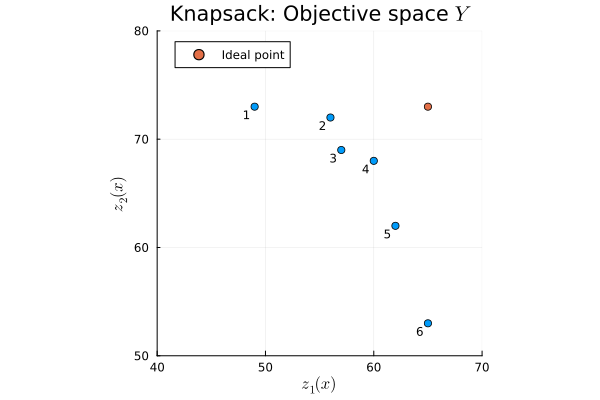

In [30]:
Plots.scatter(
      [value(objective1; result = i) for i in 1:result_count(bi01UKP)],
      [value(objective2; result = i) for i in 1:result_count(bi01UKP)];
      xlabel = "\$z_1(x)\$",
      ylabel = "\$z_2(x)\$",
      title  = "Knapsack: Objective space \$Y\$",
      label  = "",
      xlims  = (40, 70),
      ylims  = (50, 80),
      aspect_ratio=:equal
)

for i in 1:result_count(bi01UKP)
    y = objective_value(bi01UKP; result = i)
    Plots.annotate!(y[1] - 0.75, y[2] - 0.75, (i, 8))
end

ideal_point = objective_bound(bi01UKP)
Plots.scatter!([ideal_point[1]], [ideal_point[2]]; label = "Ideal point")

----
### 4. using this learning, implement the required codes to solve instances of the bi-objective General Assignment Problem (biGAP).

#### formulation

Consider the following bi-objective generalized assignment (biGAP) problem:

$$\big ( \ \max \sum_{i=1}^{m} \sum_{j=1}^{n} p^1_{ij} x_{ij} \ , \
\max \sum_{i=1}^{m} \sum_{j=1}^{n} p^2_{ij} x_{ij} \ \big )$$

$$ s.t \qquad \sum_{j=1}^{n} w_{ij} x_{ij} \le b_i, \quad \forall i \in \{1, \dots, m \}$$

$$ \qquad \qquad \sum_{i=1}^{m} x_{ij} = 1, \quad \forall j \in \{1, \dots, n \}$$


$$x_{ij}\in\{0,1\}, \ \forall i \in \{1, \dots, m \}, \  \forall j \in \{1, \dots, n \}$$

#### generator of instances

Generate an instance $m\times n$ with coefficients randomly generated as follow:
- $1 \le p^1_{ij}, \ p^2_{ij}, \ w_{ij} \le 10$ 
- $b_i = \lfloor  \frac{\sum_{j=1}^{m}w_{ij}}{2} \rfloor$ 

#### questions

- generate a numerical instance
- compute $Y_N$, the set of non-dominated points, using HiGHS as MIP solver
- compute $U$, an upper bound set of $Y_N$, using HiGHS as MIP solver
- plot on a same figure $Y_N$ and $U$

In [11]:
m=3; n=10
p1 = rand(1:10,m,n)
p2 = rand(1:10,m,n)
w  = rand(1:10,m,n)
b  = Vector{Int64}(undef,m)
for i=1:m
    b[i] = floor(Int64,sum(w[i,:])/2.0) 
end

biGAP with variables in $\{0,1\}$ solved with the epsilon-constraint method using GLPK: 

In [12]:
using JuMP
using HiGHS
import MultiObjectiveAlgorithms as MOA

GAP = Model()
@variable(GAP, x[1:m, 1:n], Bin)
@expression(GAP, objective1, sum(p1[i,j]*x[i,j] for i = 1:m, j = 1:n) )
@expression(GAP, objective2, sum(p2[i,j]*x[i,j] for i = 1:m, j = 1:n) )
@objective(GAP, Max, [objective1,objective2])
@constraint(GAP, [i=1:m], sum(w[i,j]*x[i,j] for j = 1:n) <= b[i])
@constraint(GAP, [j=1:n], sum(x[i,j] for i = 1:m) == 1)

set_optimizer(GAP, () -> MOA.Optimizer(HiGHS.Optimizer))
set_attribute(GAP, MOA.Algorithm(), MOA.EpsilonConstraint())
set_silent(GAP)
optimize!(GAP)

YN = []
for i in 1:result_count(GAP)
    y = round.(Int, objective_value(GAP; result = i))
    push!(YN,y)
    println(i, ": z = ", y)
end

1: z = [54, 87]
2: z = [57, 85]
3: z = [58, 83]
4: z = [61, 82]
5: z = [62, 81]
6: z = [64, 80]
7: z = [65, 79]
8: z = [66, 77]
9: z = [67, 76]
10: z = [68, 75]
11: z = [70, 73]
12: z = [71, 71]
13: z = [73, 69]
14: z = [74, 67]
15: z = [75, 63]
16: z = [76, 57]


In [13]:
relax = relax_integrality(GAP) # all variables are continuous

set_attribute(GAP, MOA.Algorithm(), MOA.Dichotomy())
#set_attribute(GAP, MOA.EpsilonConstraintStep(), 0.5)
optimize!(GAP)

U = []
for i in 1:result_count(GAP)
    y = objective_value(GAP; result = i)
    push!(U,y)
    println(i, ": z = ", y)
end

relax() # restore the definition of variables

1: z = [76.0, 57.0]
2: z = [76.0, 58.5]
3: z = [75.44444444444446, 61.555555555555564]
4: z = [74.22222222222221, 66.77777777777777]
5: z = [73.88888888888889, 68.11111111111111]
6: z = [70.88888888888889, 72.11111111111111]
7: z = [70.25, 72.875]
8: z = [65.0, 79.0]
9: z = [64.0, 80.0]
10: z = [57.0, 85.0]
11: z = [54.0, 87.0]


In [14]:
yfirst = copy(U[1])
ylast = copy(U[end])
@show yfirst, ylast
yfirst[2]=0.0
ylast[1]=0.0
@show yfirst, ylast
pushfirst!(U,yfirst)
push!(U,ylast)

(yfirst, ylast) = ([76.0, 57.0], [54.0, 87.0])
(yfirst, ylast) = ([76.0, 0.0], [0.0, 87.0])


13-element Vector{Any}:
 [76.0, 0.0]
 [76.0, 57.0]
 [76.0, 58.5]
 [75.44444444444446, 61.555555555555564]
 [74.22222222222221, 66.77777777777777]
 [73.88888888888889, 68.11111111111111]
 [70.88888888888889, 72.11111111111111]
 [70.25, 72.875]
 [65.0, 79.0]
 [64.0, 80.0]
 [57.0, 85.0]
 [54.0, 87.0]
 [0.0, 87.0]

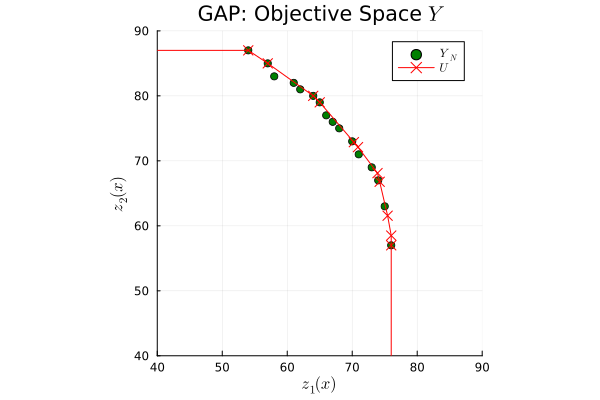

In [31]:
using Plots

Plots.scatter(
      [YN[i][1] for i in 1:length(YN)],
      [YN[i][2] for i in 1:length(YN)];
      aspect_ratio=:equal,
      markercolor = :green,
      xlabel = "\$z_1(x)\$",
      ylabel = "\$z_2(x)\$",
      title  = "GAP: Objective Space \$Y\$",
      label  = "\$Y_N\$",
      xlims  = (40, 80),
      ylims  = (40, 80),
)
Plots.plot!(
      [U[i][1] for i in 1:length(U)],
      [U[i][2] for i in 1:length(U)];
      linecolor = :red,
      markershape = :xcross,
      markercolor = :red,
      markersize = 5,
      label  = "\$U\$",
      xlims  = (40, 90),
      ylims  = (40, 90),
)
